# 📈 Hypergraph Neural Network (HGNN) for Stock Feature Learning

This notebook loads multi-ticker stock data, constructs hypergraphs, and trains an HGNN model to learn and predict stock-related features.


## 📦 1. Imports
Necessary Python libraries for data handling, modeling, and visualization.


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

## 📊 2. Data Loading & Preprocessing

This function loads stock data for multiple tickers, calculates moving averages and returns, normalizes the features, and returns a tensor representation of each ticker.


In [ ]:
def compute_features(df):
    df = df.sort_values(by=["Ticker", "Date"])
    df['MA_5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean())
    df['MA_10'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10).mean())
    df['returns'] = df.groupby('Ticker')['Close'].pct_change()
    df = df.dropna()
    return df

def load_stock_data(path):
    df = pd.read_csv(path)
    print("Original columns:", df.columns.tolist())

    tickers = ['AAPL', 'AMZN', 'BA', 'BAC', 'C', 'CAT', 'CVX', 'DUK', 'GOOGL', 'JNJ',
               'JPM', 'KO', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'VZ', 'WMT', 'XOM']

    ticker_to_idx = {ticker: i for i, ticker in enumerate(tickers)}
    print("Ticker to index mapping:", ticker_to_idx)

    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    all_ticker_data = []

    for i in range(len(tickers)):
        suffix = '' if i == 0 else f'.{i}'
        col_names = [f + suffix for f in features]

        if not all(col in df.columns for col in col_names):
            print(f"Skipping ticker {tickers[i]} - columns not found")
            continue

        try:
            sub_df = df[["Date"] + col_names].copy()
            sub_df.columns = ["Date"] + features
            sub_df['Ticker'] = tickers[i]
            all_ticker_data.append(sub_df)
        except Exception as e:
            print(f"Skipping ticker {tickers[i]} due to error: {e}")
            continue

    full_df = pd.concat(all_ticker_data, ignore_index=True)
    full_df = full_df.dropna()

    # Compute additional features
    full_df = compute_features(full_df)
    features += ['MA_5', 'MA_10', 'returns']  # Add new features

    # Normalize features
    scaler = StandardScaler()
    full_df[features] = scaler.fit_transform(full_df[features])

    # Convert to tensor: per-ticker mean feature
    data_tensor = torch.zeros(len(tickers), len(features))
    for ticker in tickers:
        if ticker in full_df['Ticker'].unique():
            ticker_data = full_df[full_df['Ticker'] == ticker][features].mean().values
            data_tensor[ticker_to_idx[ticker]] = torch.tensor(ticker_data, dtype=torch.float32)

    return data_tensor, ticker_to_idx, full_df, scaler, features


## 🧩 3. Hypergraph Construction

Reads hyperedges from a JSON file and builds the incidence matrix `H`.


In [ ]:
def generate_hypergraph_incidence_from_file(label_dict, json_path):
    with open(json_path, 'r') as f:
        hyperedges = json.load(f)

    num_nodes = len(label_dict)
    num_edges = len(hyperedges)
    H = torch.zeros((num_nodes, num_edges))

    for j, edge in enumerate(hyperedges):
        for ticker in edge:
            if ticker in label_dict:
                i = label_dict[ticker]
                H[i, j] = 1

    return H

## 🎯 4. Feature Preparation for Supervision

Constructs the training features and target labels for the model.


In [ ]:
def prepare_features_and_labels(X, label_dict, original_df, features):
    y = torch.zeros_like(X)
    for ticker, idx in label_dict.items():
        if ticker in original_df['Ticker'].unique():
            ticker_data = original_df[original_df['Ticker'] == ticker][features].mean().values
            y[idx] = torch.tensor(ticker_data, dtype=torch.float32)
    return X, y

## 🧠 5. Model Definition - HGNN Layer



In [ ]:
class HGNNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(HGNNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.norm = nn.BatchNorm1d(out_features)


    def forward(self, x, H):
    # Hypergraph convolution with normalization
        epsilon = 1e-8  # small constant to avoid division by zero

        D_v = torch.diag(H.sum(1))
        D_e = torch.diag(H.sum(0))

        # Add epsilon to diagonal elements to avoid zero
        D_v = D_v + epsilon * torch.eye(D_v.size(0), device=H.device)
        D_e = D_e + epsilon * torch.eye(D_e.size(0), device=H.device)

        D_v_inv_sqrt = torch.linalg.inv(torch.sqrt(D_v))
        D_e_inv = torch.linalg.inv(D_e)

        # Normalized hypergraph convolution
        x = D_v_inv_sqrt @ H @ D_e_inv @ H.T @ D_v_inv_sqrt @ x
        x = self.linear(x)
        x = self.norm(x)
        return F.relu(x)

## 🧠 6. HGNN Model

Stacks multiple HGNN layers followed by a final linear output.


In [ ]:
class HGNN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, num_layers=2):
        super(HGNN, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(HGNNLayer(in_features, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(HGNNLayer(hidden_dim, hidden_dim))

        # Output layer
        self.output = nn.Linear(hidden_dim, out_features)

    def forward(self, x, H):
        for layer in self.layers:
            x = layer(x, H)
        return self.output(x)

## 📏 7. Evaluation

Evaluates the model using both Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE).


In [ ]:
def evaluate(model, val_df, full_train_df, H, scaler, features):
    model.eval()

    # Convert features to list if it's not already
    if not isinstance(features, list):
        features = [features] if isinstance(features, str) else list(features)

    eval_tickers = []
    ticker_features = []
    true_features = []

    grouped_val = val_df.groupby('Ticker')

    for ticker in sorted(grouped_val.groups.keys()):
        group_val = grouped_val.get_group(ticker)

        if len(group_val) == 0:
            continue

        true_feat = group_val[features].iloc[0].values
        if np.any(np.isnan(true_feat)):
            print(f"Skipping {ticker}: NaN in y_true")
            continue

        group_train = full_train_df[full_train_df['Ticker'] == ticker]
        if len(group_train) == 0:
            continue

        feat = group_train[features].mean().values
        if np.any(np.isnan(feat)):
            print(f"Skipping {ticker}: NaN in training features")
            continue

        true_features.append(true_feat)
        ticker_features.append(feat)
        eval_tickers.append(ticker)

    if len(ticker_features) == 0:
        print("No valid tickers found for evaluation.")
        return None

    # Build H matrix only for current evaluation tickers
    H_eval = np.zeros((len(eval_tickers), H.shape[1]))
    ticker_to_idx = {ticker: i for i, ticker in enumerate(eval_tickers)}

    with open('hyperedges.json', 'r') as f:
        hyperedges = json.load(f)

    for j, edge in enumerate(hyperedges):
        for ticker in edge:
            if ticker in ticker_to_idx:
                i = ticker_to_idx[ticker]
                H_eval[i][j] = 1

    H_eval = torch.tensor(H_eval, dtype=torch.float32)

    # Convert features to tensors
    X = torch.tensor(np.stack(ticker_features), dtype=torch.float32)

    with torch.no_grad():
        y_pred = model(X, H_eval).numpy()

    y_true = np.stack(true_features)

    # Calculate both MSE and MAPE
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"Validation MSE: {mse:.4f}, Validation MAPE: {mape:.4f}")
    return mse, mape


## 🚀 8. Training Loop with Early Stopping and Visualization


In [ ]:
def train_model(X_train, y_train, H_train, X_val, y_val, H_val,
                val_df, full_train_df, scaler, features,
                num_epochs=200, lr=0.01, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = HGNN(
        in_features=X_train.size(1),
        hidden_dim=64,
        out_features=y_train.size(1),
        num_layers=3
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    # Move data to device
    X_train, y_train, H_train = X_train.to(device), y_train.to(device), H_train.to(device)
    X_val, y_val, H_val = X_val.to(device), y_val.to(device), H_val.to(device)

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    val_losses = []
    val_mapes = []

    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train, H_train)
        loss = loss_fn(outputs, y_train)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val, H_val)
            val_loss = loss_fn(val_outputs, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Calculate validation MAPE periodically
        if (epoch + 1) % 10 == 0:
            _, val_mape = evaluate(model, val_df, full_train_df, H_val.cpu(), scaler, features)
            val_mapes.append(val_mape)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print(f"Train MSE: {loss.item():.4f}, Val MSE: {val_loss.item():.4f}")
            if val_mapes:
                print(f"Recent Val MAPE: {val_mapes[-1]:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_mapes, label='Validation MAPE')
    plt.xlabel('Every 10 Epochs')
    plt.ylabel('MAPE')
    plt.legend()
    plt.title('Validation MAPE Over Time')

    plt.tight_layout()
    plt.show()

    return model

#  9. Prediction for Blind Test Cases

In [ ]:

def predict_blind_test(model, blind_test_cases, train_df, H, ticker_to_idx, scaler, features):
    updated_cases = []

    with open('hyperedges.json', 'r') as f:
        hyperedges = json.load(f)

    for case in tqdm(blind_test_cases, desc="Predicting blind test cases"):
        ticker = case['ticker']
        date = case['date']

        if ticker not in ticker_to_idx:
            print(f"Skipping {ticker} - not in training data")
            continue

        # Get the most recent data for this ticker
        ticker_data = train_df[train_df['Ticker'] == ticker]
        if len(ticker_data) == 0:
            print(f"Skipping {ticker} - no training data available")
            continue

        # Get the last available data point
        recent = ticker_data[features].values[-1:]
        recent_tensor = torch.tensor(recent, dtype=torch.float32)

        # Rebuild H for just this one ticker
        idx = ticker_to_idx[ticker]
        H_single = H[idx:idx+1, :]

        # Predict
        with torch.no_grad():
            pred = model(recent_tensor.to(next(model.parameters()).device),
                        H_single.to(next(model.parameters()).device))
            pred = pred.cpu().numpy()

        # Inverse transform predictions
        scaled_pred = scaler.inverse_transform(pred.reshape(1, -1))[0]

        # Update case with predictions
        case['predicted_open'] = float(scaled_pred[0])
        case['predicted_high'] = float(scaled_pred[1])
        case['predicted_low'] = float(scaled_pred[2])
        case['predicted_close'] = float(scaled_pred[3])
        case['predicted_volume'] = float(scaled_pred[4])
        case['eval_metric'] = "MAPE"
        updated_cases.append(case)

    return updated_cases


# 10. Main Execution

Original columns: ['Date', 'Ticker', 'Open', 'Open.1', 'Open.2', 'Open.3', 'Open.4', 'Open.5', 'Open.6', 'Open.7', 'Open.8', 'Open.9', 'Open.10', 'Open.11', 'Open.12', 'Open.13', 'Open.14', 'Open.15', 'Open.16', 'Open.17', 'Open.18', 'Open.19', 'High', 'High.1', 'High.2', 'High.3', 'High.4', 'High.5', 'High.6', 'High.7', 'High.8', 'High.9', 'High.10', 'High.11', 'High.12', 'High.13', 'High.14', 'High.15', 'High.16', 'High.17', 'High.18', 'High.19', 'Low', 'Low.1', 'Low.2', 'Low.3', 'Low.4', 'Low.5', 'Low.6', 'Low.7', 'Low.8', 'Low.9', 'Low.10', 'Low.11', 'Low.12', 'Low.13', 'Low.14', 'Low.15', 'Low.16', 'Low.17', 'Low.18', 'Low.19', 'Close', 'Close.1', 'Close.2', 'Close.3', 'Close.4', 'Close.5', 'Close.6', 'Close.7', 'Close.8', 'Close.9', 'Close.10', 'Close.11', 'Close.12', 'Close.13', 'Close.14', 'Close.15', 'Close.16', 'Close.17', 'Close.18', 'Close.19', 'Volume', 'Volume.1', 'Volume.2', 'Volume.3', 'Volume.4', 'Volume.5', 'Volume.6', 'Volume.7', 'Volume.8', 'Volume.9', 'Volume.10', 

Training:   3%|▎         | 14/500 [00:00<00:03, 139.52it/s]

Validation MSE: 0.8650, Validation MAPE: 1.0233

Epoch 10/500
Train MSE: 0.6357, Val MSE: 0.3310
Recent Val MAPE: 1.0233
Validation MSE: 0.8630, Validation MAPE: 1.0123

Epoch 20/500
Train MSE: 0.6248, Val MSE: 0.3289
Recent Val MAPE: 1.0123


Training:   6%|▌         | 30/500 [00:00<00:03, 122.90it/s]

Validation MSE: 0.8646, Validation MAPE: 1.0016

Epoch 30/500
Train MSE: 0.6234, Val MSE: 0.3283
Recent Val MAPE: 1.0016


Training:   9%|▉         | 47/500 [00:00<00:03, 141.04it/s]

Validation MSE: 0.8625, Validation MAPE: 0.9798

Epoch 40/500
Train MSE: 0.6229, Val MSE: 0.3279
Recent Val MAPE: 0.9798
Validation MSE: 0.8593, Validation MAPE: 0.9589

Epoch 50/500
Train MSE: 0.6224, Val MSE: 0.3269
Recent Val MAPE: 0.9589


Training:  12%|█▏        | 62/500 [00:00<00:03, 124.50it/s]

Validation MSE: 0.8585, Validation MAPE: 0.9544

Epoch 60/500
Train MSE: 0.6224, Val MSE: 0.3272
Recent Val MAPE: 0.9544


Training:  14%|█▍        | 70/500 [00:00<00:03, 125.40it/s]

Validation MSE: 0.8585, Validation MAPE: 0.9480

Epoch 70/500
Train MSE: 0.6223, Val MSE: 0.3276
Recent Val MAPE: 0.9480
Early stopping at epoch 71


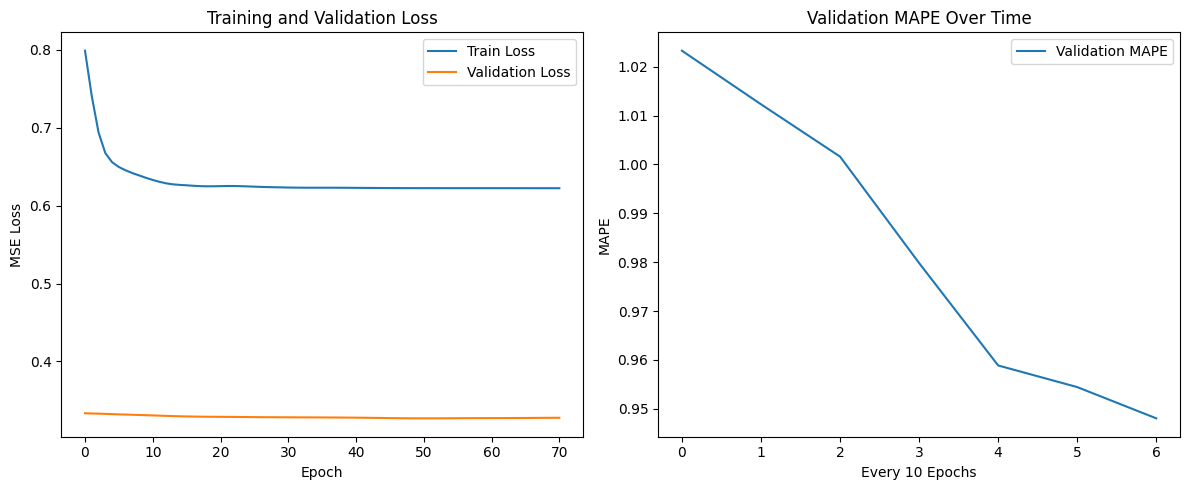


Final Evaluation:
Validation MSE: 0.8586, Validation MAPE: 0.9474
Final Validation MSE: 0.8586, MAPE: 0.9474


Predicting blind test cases: 100%|██████████| 120/120 [00:00<00:00, 217.18it/s]


Predictions saved to predicted_test_cases.json


In [ ]:

if __name__ == "__main__":
    # Load and prepare data
    X_train, label_dict, full_train_df, scaler, features = load_stock_data('train_stock_data.csv')
    X_val, label_dict_val, full_val_df, _, _ = load_stock_data('validation_stock_data.csv')

    # Prepare features and labels
    X_train, y_train = prepare_features_and_labels(X_train, label_dict, full_train_df, features)
    X_val, y_val = prepare_features_and_labels(X_val, label_dict_val, full_val_df, features)

    # Generate hypergraph incidence matrices
    H_train = generate_hypergraph_incidence_from_file(label_dict, 'hyperedges.json')
    H_val = generate_hypergraph_incidence_from_file(label_dict_val, 'hyperedges.json')

    print("\nData Shapes:")
    print(f"Train Features: {X_train.shape}, Train Labels: {y_train.shape}")
    print(f"Val Features: {X_val.shape}, Val Labels: {y_val.shape}")
    print(f"Train Incidence: {H_train.shape}, Val Incidence: {H_val.shape}")

    # Train model
    model = train_model(
        X_train, y_train, H_train,
        X_val, y_val, H_val,
        val_df=full_val_df,
        full_train_df=full_train_df,
        scaler=scaler,
        features=features,
        num_epochs=500,
        lr=0.001,
        patience=20
    )

    # Final evaluation
    print("\nFinal Evaluation:")
    final_mse, final_mape = evaluate(model, full_val_df, full_train_df, H_val, scaler, features)
    print(f"Final Validation MSE: {final_mse:.4f}, MAPE: {final_mape:.4f}")

    # Load blind test cases and make predictions
    with open('blind_test_cases.json', 'r') as f:
        blind_test_cases = json.load(f)

    updated_cases = predict_blind_test(
        model, blind_test_cases,
        full_train_df, H_train,
        label_dict, scaler, features
    )

    # Save predictions
    with open("predicted_test_cases.json", "w") as f:
        json.dump(updated_cases, f, indent=4)
    print("\nPredictions saved to predicted_test_cases.json")